# Implementation and evaluation of models for Cross-subject classification

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import sys, os
import h5py
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

np.random.seed(0)

### Data utils

In [0]:
def get_dataset_name(file_name_with_dir):
    filename_without_dir = file_name_with_dir.split('/')[-1]
    temp = filename_without_dir.split('_')[:-1]
    dataset_name = "_".join(temp)
    return dataset_name


def normalize(matrix, class_id, maxs_array, mins_array):
  maxs = maxs_array[:, class_id]
  maxs = maxs.reshape(maxs.shape[0],1)
  mins = mins_array[:, class_id]
  mins = mins.reshape(mins.shape[0],1)
  return (matrix-mins)/(maxs-mins)

def subsample(matrix, downsampling_factor=10):
  return matrix[:, ::downsampling_factor]

### Data generators

In [0]:
def train_val_generator(train_data_dir, mode='training', downsampling_factor=10, val_split=0.2, shuffle=False, window_size=1000, window_shift=50, maxs_array=None, mins_array=None):
  '''
  Generate 4 chunk, one one class
  '''
  
  class_names=['rest', 'task_motor', 'task_story_math', 'task_working_memory']
  
  subject_id_list = [113922, 164636]
  sub_idx = 0
  chunk_id = 1

  while True:
      
    np.random.seed(chunk_id)
    
    # Initialize the dataset
    data_X = []
    data_Y = []

    subject_id = subject_id_list[sub_idx]

    for class_id, class_name in enumerate(class_names):
      filename_path = train_data_dir + '/' + class_name + '_' + str(subject_id) + '_' + str(chunk_id) + '.h5'

      ### Supplied code
      with h5py.File(filename_path,'r') as f:
        dataset_name = get_dataset_name(filename_path)
        matrix = f.get(dataset_name)[()]
      ###

      matrix = normalize(matrix, class_id, maxs_array, mins_array)
      matrix = subsample(matrix, downsampling_factor)
      matrix = matrix.T
      for i in range(window_size-1, matrix.shape[0], window_shift):
        x_instance = matrix[i-window_size+1: i+1, :]
        data_X.append(x_instance)
        data_Y.append(class_id)


    data_X = np.asarray(data_X)
    data_X = data_X.astype(np.float16)
    data_Y = np.asarray(data_Y).astype(np.int8)


    # Shuffle
    if shuffle:
      indices = np.arange(data_X.shape[0])
      np.random.shuffle(indices)
      data_X = data_X[indices,:,:]
      data_Y = data_Y[indices]
        
    n_instances = data_X.shape[0]
    n_instances_train = round((1-val_split)*n_instances)
    
    if mode == 'training':
      # Take first 'n_instances_train' instances of the dataset
      #print("\nYielding: Sub {}  |  Chunk set {} (training)".format(subject_id_list[sub_idx], chunk_id))
      yield data_X[:n_instances_train,:,:], data_Y[:n_instances_train]


    if mode == 'validation':
      # Take the remaining instances as validation set
      yield data_X[n_instances_train:,:,:], data_Y[n_instances_train:]


    chunk_id += 1
    if chunk_id > 8:
      chunk_id = 1

      sub_idx += 1
      if sub_idx > 1:
        sub_idx = 0

      #raise Exception("All files yielded")
  

def test_generator(test_data_dir, downsampling_factor=10, window_size=1000, window_shift=50, maxs_array=None, mins_array=None):
  '''
  Generate data from a single h5 file 
  '''
  
  class_names_list=['rest','task_motor','task_story_math','task_working_memory']

  file_names = sorted(os.listdir(test_data_dir))

  while True:

    for file_name in file_names:
      # Initialize the dataset
      test_data_X = []
      test_data_Y = []
      
      filename_path = test_data_dir + file_name
      class_name = '_'.join((file_name.split('_')[:-2]))
      class_id = class_names_list.index(class_name)

      ### Supplied code
      with h5py.File(filename_path,'r') as f:
        dataset_name = get_dataset_name(filename_path)
        matrix = f.get(dataset_name)[()]
      ###

      matrix = normalize(matrix, class_id, maxs_array, mins_array)
      matrix = subsample(matrix, downsampling_factor)
      matrix = matrix.T
      for i in range(window_size-1, matrix.shape[0], window_shift):
        x_instance = matrix[i-window_size+1: i+1, :]
        test_data_X.append(x_instance)
        test_data_Y.append(class_id)

      test_data_X = np.asarray(test_data_X).astype(np.float16)
      test_data_Y = np.asarray(test_data_Y).astype(np.int8)

      # print("Yielding chunk set: ",chunk_id)
      yield test_data_X, test_data_Y



### Configuration


In [0]:
# CROSS train 

train_data_dir = "/content/drive/My Drive/DL-final_project/Data/Cross/train/"
cross_base_dir = "/content/drive/My Drive/DL-final_project/Data/Cross"

train_subject_id_list = [113922, 164636]

class_names = ['rest', 'task_motor', 'task_story_math', 'task_working_memory']
n_sensors = 248        # FIXED: No. of features (sensors) in the signal
steps_per_file = 35624 # FIXED


# Data preprocessing params
DOWNSAMPLING_FACTOR = 10
WINDOW_SIZE = 100
WINDOW_SHIFT = 10
VAL_SPLIT = 0.2
SHUFFLE = True

# Baseline hyper-params
HYPER_PARAMS = {'lr': 0.001, 'batch_norm':False, 'dropout_prob':0.0}
N_CONV_LAYERS = 3
KERNELS = [32,32,64]
KERNEL_SIZES = [3,3,3]

# Training
EPOCHS = 50

# Normalization stuff
maxs_file_path = "/content/drive/My Drive/DL-final_project/data_stats/cross_train_maxs.txt"
mins_file_path = "/content/drive/My Drive/DL-final_project/data_stats/cross_train_mins.txt"
maxs_array = np.loadtxt(maxs_file_path, delimiter=',')
mins_array = np.loadtxt(mins_file_path, delimiter=',')

### Model definition

In [0]:
def CNN_model_cross(window_size, n_conv_layers, kernels, kernel_sizes, hyper_params={'lr':0.001, 'batch_norm':False, 'dropout_prob':0.0}, initializer='glorot_uniform'):
    tf.random.set_seed(0)
    tf.keras.backend.clear_session()

    model = models.Sequential()
    model.add(layers.Conv1D(filters=kernels[0], kernel_size=kernel_sizes[0], strides=1, 
                            activation='relu', 
                            kernel_initializer=initializer,
                            input_shape=(window_size, 248)))

    if hyper_params['batch_norm']:
      model.add(layers.BatchNormalization())

    for i in range(1, n_conv_layers):
        model.add(layers.Conv1D(filters=kernels[i], kernel_size=kernel_sizes[i], strides=1, activation='relu', kernel_initializer=initializer))
        if hyper_params['batch_norm']:
          model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling1D(pool_size=2))
    
    model.add(layers.Flatten())

    model.add(layers.Dense(units=64, activation='relu', kernel_initializer=initializer))
    if hyper_params['dropout_prob'] != 0.0:
      model.add(layers.Dropout(hyper_params['dropout_prob']))

    model.add(layers.Dense(units=64, activation='relu', kernel_initializer=initializer))
    if hyper_params['dropout_prob'] != 0.0:
      model.add(layers.Dropout(hyper_params['dropout_prob']))

    model.add(layers.Dense(units=4, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hyper_params['lr']),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    return model

#model = CNN_model_cross(window_size=100, n_conv_layers=6, kernels=[32,32,64,64,128,256], kernel_sizes=[3,3,3,3,3,3])


### Baseline model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 98, 32)            23840     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 32)            3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 48, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 46, 64)            6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 23, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1472)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                9

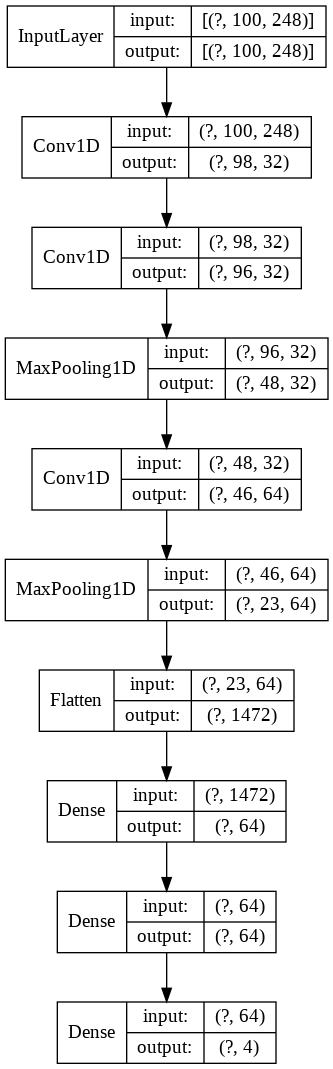

In [30]:
# Baseline hyper-params
baseline = CNN_model_cross(WINDOW_SIZE,
                    N_CONV_LAYERS, KERNELS, KERNEL_SIZES, 
                    HYPER_PARAMS)

tf.keras.utils.plot_model(baseline, 
                          to_file='/content/drive/My Drive/DL-final_project/Results/Cross/baseline_arch.png', 
                          show_shapes=True, show_layer_names=False,
                          rankdir='TB', expand_nested=False, dpi=96)

## Experiment 1: Number of Layers

In [0]:
# Sweep config

n_conv_layers_list = [3, 4, 5, 6]
kernels_list = [[32,32,64],
                [32,32,64,64],
                [32,32,64,64,128],
                [32,32,64,64,128,256]]
kernel_sizes_list = [[3,3,3],
                     [3,3,3,3],
                     [3,3,3,3,3],
                     [3,3,3,3,3,3]]

n_conv_layers_list = [6]
kernels_list = [[32,32,64,64,128,256]]
kernel_sizes_list = [[3,3,3,3,3,3]]

# Callback config
base_log_dir = "/content/drive/My Drive/DL-final_project/Results/Cross/Expt1-nLayers/logs/"

In [0]:
for i, n_conv_layers in enumerate(n_conv_layers_list):
  # Set up callback
  log_dir = base_log_dir + str(n_conv_layers) + "_layer/"
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=False,
      update_freq='epoch', profile_batch=2, embeddings_freq=0,
      embeddings_metadata=None)

  # Initialize data generators
  train_generator = train_val_generator(train_data_dir,
                                                 'training', DOWNSAMPLING_FACTOR, VAL_SPLIT, SHUFFLE, 
                                                 WINDOW_SIZE, WINDOW_SHIFT, 
                                                 maxs_array, mins_array)

  val_generator = train_val_generator(train_data_dir, 
                                               'validation', DOWNSAMPLING_FACTOR, VAL_SPLIT, SHUFFLE, 
                                               WINDOW_SIZE, WINDOW_SHIFT, 
                                               maxs_array, mins_array)

  # Initialize model
  kernels = kernels_list[i]
  kernel_sizes = kernel_sizes_list[i]
  model = CNN_model_cross(WINDOW_SIZE,
                    n_conv_layers, kernels, kernel_sizes, 
                    HYPER_PARAMS)
  
  # Start training
  print("EXPT CASE: N Conv Layers-", n_conv_layers)
  model.fit(train_generator,
              steps_per_epoch = 16,
              validation_data = val_generator,
              validation_steps = 16,
              epochs = EPOCHS,
              callbacks=[tensorboard_callback])
             

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 98, 32)            23840     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 32)            3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 48, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 46, 64)            6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 23, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 21, 64)            12352     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 10, 64)            0

## Experiment 2: Kernel sizes

In [0]:
# Baseline config
EPOCHS=30
N_CONV_LAYERS=3
KERNELS=[32,32,64]

# Sweep config
kernel_sizes_list = [[5,3,3],
                    [5,5,3],
                    [7,3,3],
                    [7,5,3]]

# Callback config
base_log_dir = "/content/drive/My Drive/DL-final_project/Results/Cross/Expt2-kernelSize/logs/"

In [0]:
for i, kernel_sizes in enumerate(kernel_sizes_list):
  # Set up callback
  log_dir = base_log_dir +  "{}-{}-{}_kernelSize/".format(kernel_sizes[0], kernel_sizes[1], kernel_sizes[2])
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=False,
      update_freq='epoch', profile_batch=2, embeddings_freq=0,
      embeddings_metadata=None)

  # Initialize data generators
  train_generator = train_val_generator(train_data_dir, 
                                                 'training', DOWNSAMPLING_FACTOR, VAL_SPLIT, SHUFFLE, 
                                                 WINDOW_SIZE, WINDOW_SHIFT, 
                                                 maxs_array, mins_array)

  val_generator = train_val_generator(train_data_dir, 
                                               'validation', DOWNSAMPLING_FACTOR, VAL_SPLIT, SHUFFLE, 
                                               WINDOW_SIZE, WINDOW_SHIFT, 
                                               maxs_array, mins_array)

  # Initialize model
  model = CNN_model_cross(WINDOW_SIZE,
                    N_CONV_LAYERS, KERNELS, kernel_sizes, 
                    HYPER_PARAMS)
  
  # Start training
  print("EXPT CASE:  Kernel sizes-", kernel_sizes)
  model.fit(train_generator,
              steps_per_epoch = 16,
              validation_data = val_generator,
              validation_steps = 16,
              epochs = EPOCHS,
              callbacks=[tensorboard_callback])
             

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 96, 32)            39712     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 94, 32)            3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 47, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 45, 64)            6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 22, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                9

## Experiment 3: Batch normalization

In [0]:
# Callback config
base_log_dir = "/content/drive/My Drive/DL-final_project/Results/Cross/Expt3-batchNorm/logs/"
EPOCHS=30

for batch_norm in [False, True]:

  # Set up callback
  log_dir = base_log_dir +  "{}_batchNorm/".format(int(batch_norm))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=False,
      update_freq='epoch', profile_batch=2, embeddings_freq=0,
      embeddings_metadata=None)

  # Initialize data generators
  train_generator = train_val_generator(train_data_dir, 
                                                 'training', DOWNSAMPLING_FACTOR, VAL_SPLIT, SHUFFLE, 
                                                 WINDOW_SIZE, WINDOW_SHIFT, 
                                                 maxs_array, mins_array)

  val_generator = train_val_generator(train_data_dir, 
                                               'validation', DOWNSAMPLING_FACTOR, VAL_SPLIT, SHUFFLE, 
                                               WINDOW_SIZE, WINDOW_SHIFT, 
                                               maxs_array, mins_array)

  # Initialize model
  model = CNN_model_cross(WINDOW_SIZE,
                    N_CONV_LAYERS, KERNELS, KERNEL_SIZES, 
                    hyper_params={'lr':0.001, 'batch_norm':batch_norm, 'dropout_prob':0.0})
  
  # Start training
  print("EXPT CASE:  Batch norm-", batch_norm)
  model.fit(train_generator,
              steps_per_epoch = 16,
              validation_data = val_generator,
              validation_steps = 16,
              epochs = EPOCHS,
              callbacks=[tensorboard_callback])
             

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 98, 32)            23840     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 32)            3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 48, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 46, 64)            6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 23, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1472)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                9

## Experiment 4: Dropout regularization

In [0]:
# Sweep config
dropout_prob_list = [0.1, 0.15, 0.2]
EPOCHS=50

base_log_dir = "/content/drive/My Drive/DL-final_project/Results/Cross/Expt4-dropout/logs/"

In [0]:
for dropout_prob in dropout_prob_list:
   # Set up callback
  log_dir = base_log_dir +  "{}_dropout/".format(dropout_prob)
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=False,
      update_freq='epoch', profile_batch=2, embeddings_freq=0,
      embeddings_metadata=None)

  # Initialize data generators
  train_generator = train_val_generator(train_data_dir, 
                                                 'training', DOWNSAMPLING_FACTOR, VAL_SPLIT, SHUFFLE, 
                                                 WINDOW_SIZE, WINDOW_SHIFT, 
                                                 maxs_array, mins_array)

  val_generator = train_val_generator(train_data_dir, 
                                               'validation', DOWNSAMPLING_FACTOR, VAL_SPLIT, SHUFFLE, 
                                               WINDOW_SIZE, WINDOW_SHIFT, 
                                               maxs_array, mins_array)

  # Initialize model
  model = CNN_model_cross(WINDOW_SIZE,
                    N_CONV_LAYERS, KERNELS, KERNEL_SIZES, 
                    hyper_params={'lr':0.001, 'batch_norm':False, 'dropout_prob':dropout_prob})
  
  # Start training
  print("EXPT CASE: Dropout-", dropout_prob)
  model.fit(train_generator,
              steps_per_epoch = 16,
              validation_data = val_generator,
              validation_steps = 16,
              epochs = EPOCHS,
              callbacks=[tensorboard_callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 98, 32)            23840     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 32)            3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 48, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 46, 64)            6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 23, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1472)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                9

## Experiment 5: Learning rate tuning 

In [0]:
# Sweep config
learning_rate_list = [0.005, 0.007, 0.01]
EPOCHS=40

base_log_dir = "/content/drive/My Drive/DL-final_project/Results/Cross/Expt5-learningRate/logs/"

In [0]:
for i, learning_rate in enumerate(learning_rate_list):
  # Set up callback
  log_dir = base_log_dir +  "{}_learningRate/".format(learning_rate)
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=False,
      update_freq='epoch', profile_batch=2, embeddings_freq=0,
      embeddings_metadata=None)

  # Initialize data generators
  train_generator = train_val_generator(train_data_dir, 
                                                 'training', DOWNSAMPLING_FACTOR, VAL_SPLIT, SHUFFLE, 
                                                 WINDOW_SIZE, WINDOW_SHIFT, 
                                                 maxs_array, mins_array)

  val_generator = train_val_generator(train_data_dir, 
                                               'validation', DOWNSAMPLING_FACTOR, VAL_SPLIT, SHUFFLE, 
                                               WINDOW_SIZE, WINDOW_SHIFT, 
                                               maxs_array, mins_array)

  # Initialize model
  model = CNN_model_cross(WINDOW_SIZE,
                    N_CONV_LAYERS, KERNELS, KERNEL_SIZES, 
                    hyper_params={'lr':learning_rate, 'batch_norm':False, 'dropout_prob':0.0})
  
  # Start training
  print("\nEXPT CASE: Learning rate-", learning_rate)
  model.fit(train_generator,
              steps_per_epoch = 16,
              validation_data = val_generator,
              validation_steps = 16,
              epochs = EPOCHS,
              callbacks=[tensorboard_callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 98, 32)            23840     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 32)            3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 48, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 46, 64)            6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 23, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1472)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                9

16/16 [==============================] - 220s 14s/step - loss: 1.3560 - accuracy: 0.3731 - val_loss: 1.0856 - val_accuracy: 0.4822
Epoch 2/40
16/16 [==============================] - 216s 13s/step - loss: 1.0550 - accuracy: 0.4638 - val_loss: 0.9603 - val_accuracy: 0.4820
Epoch 3/40
16/16 [==============================] - 215s 13s/step - loss: 1.3262 - accuracy: 0.3586 - val_loss: 1.3284 - val_accuracy: 0.2579
Epoch 4/40
16/16 [==============================] - 226s 14s/step - loss: 1.3140 - accuracy: 0.3615 - val_loss: 1.2264 - val_accuracy: 0.4308
Epoch 5/40
16/16 [==============================] - 203s 13s/step - loss: 1.1150 - accuracy: 0.4983 - val_loss: 0.9643 - val_accuracy: 0.4373
Epoch 6/40
16/16 [==============================] - 202s 13s/step - loss: 1.2527 - accuracy: 0.3396 - val_loss: 1.3438 - val_accuracy: 0.2590
Epoch 7/40
16/16 [==============================] - 206s 13s/step - loss: 1.3669 - accuracy: 0.3150 - val_loss: 1.3487 - val_accuracy: 0.3997
Epoch 8/40
16/16 

## Experiment 6: Weight initialization

In [0]:
# Sweep config

initializer_list = ['glorot_normal', 
                    'zeros', 
                    'random_normal',
                    'random_uniform']

EPOCHS=30

base_log_dir = "/content/drive/My Drive/DL-final_project/Results/Cross/Expt6-weightInit/logs/"

In [0]:
for initializer in initializer_list:
     # Set up callback
  log_dir = base_log_dir +  "{}_weightInit/".format(initializer)
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=False,
      update_freq='epoch', profile_batch=2, embeddings_freq=0,
      embeddings_metadata=None)

  # Initialize data generators
  train_generator = train_val_generator(train_data_dir, 
                                                 'training', DOWNSAMPLING_FACTOR, VAL_SPLIT, SHUFFLE, 
                                                 WINDOW_SIZE, WINDOW_SHIFT, 
                                                 maxs_array, mins_array)

  val_generator = train_val_generator(train_data_dir, 
                                               'validation', DOWNSAMPLING_FACTOR, VAL_SPLIT, SHUFFLE, 
                                               WINDOW_SIZE, WINDOW_SHIFT, 
                                               maxs_array, mins_array)

  # Initialize model
  model = CNN_model_cross(WINDOW_SIZE,
                    N_CONV_LAYERS, KERNELS, KERNEL_SIZES, 
                    HYPER_PARAMS,
                    initializer)
  
  # Start training
  print("\nEXPT CASE: Initializer-", initializer)
  model.fit(train_generator,
              steps_per_epoch = 16,
              validation_data = val_generator,
              validation_steps = 16,
              epochs = EPOCHS,
              callbacks=[tensorboard_callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 98, 32)            23840     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 32)            3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 48, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 46, 64)            6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 23, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1472)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                9

## Best model

In [0]:
# Config
hyper_params_best = {'lr':0.001, 'batch_norm':False, 'dropout_prob':0.15}
n_conv_layers_best = 3
kernels_best = [32,32,64]
kernel_sizes_best = [3,3,3]

initializer_best = 'glorot_uniform'

epochs_best = 50

log_dir_best = "/content/drive/My Drive/DL-final_project/Results/Cross/BestModel/logs/"

In [8]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir_best, histogram_freq=0, write_graph=True, write_images=False,
                                                      update_freq='epoch', profile_batch=2, embeddings_freq=0,
                                                      embeddings_metadata=None)

# Initialize data generators
train_generator = train_val_generator(train_data_dir, 
                                      'training', DOWNSAMPLING_FACTOR, VAL_SPLIT, SHUFFLE, 
                                      WINDOW_SIZE, WINDOW_SHIFT, 
                                      maxs_array, mins_array)

val_generator = train_val_generator(train_data_dir, 
                                    'validation', DOWNSAMPLING_FACTOR, VAL_SPLIT, SHUFFLE, 
                                    WINDOW_SIZE, WINDOW_SHIFT, 
                                    maxs_array, mins_array)

# Initialize model
best_model = CNN_model_cross(WINDOW_SIZE,
                            n_conv_layers_best, kernels_best, kernel_sizes_best, 
                            hyper_params_best,
                            initializer_best)

# Start training
best_model.fit(train_generator,
            steps_per_epoch = 16,
            validation_data = val_generator,
            validation_steps = 16,
            epochs = epochs_best,
            callbacks=[tensorboard_callback])



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 98, 32)            23840     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 32)            3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 48, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 46, 64)            6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 23, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1472)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                9

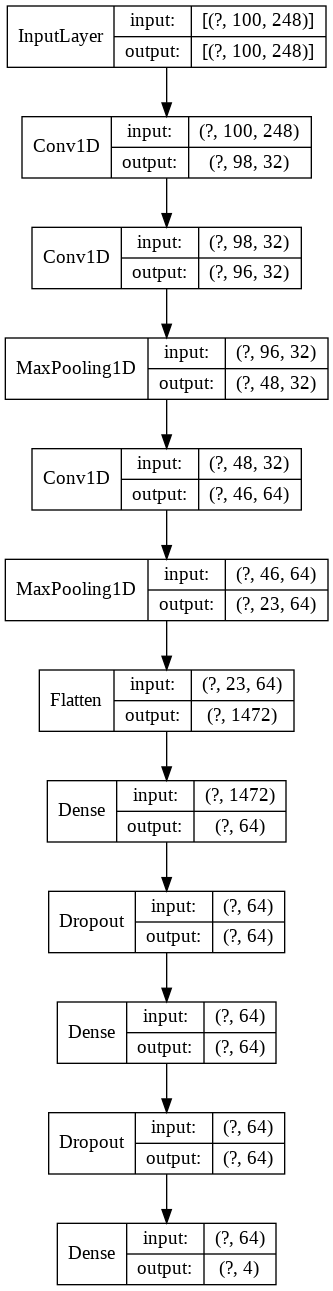

In [25]:
# Save
#print("Saving...")
#best_model.save("/content/drive/My Drive/DL-final_project/Saved models/best_model_cross.h5")

tf.keras.utils.plot_model(best_model, 
                          to_file='/content/drive/My Drive/DL-final_project/Results/Cross/BestModel/bestmodel_arch.png', 
                          show_shapes=True, show_layer_names=False,
                          rankdir='TB', expand_nested=False, dpi=96)


#### Evaluating the best model

Loading model...
Evaluating...
On Test Set 1 -----------------------------------------------------------
16/16 [==============================] - 72s 5s/step - loss: 2.6047 - accuracy: 0.9038
Accuracy: 0.9038184438040345


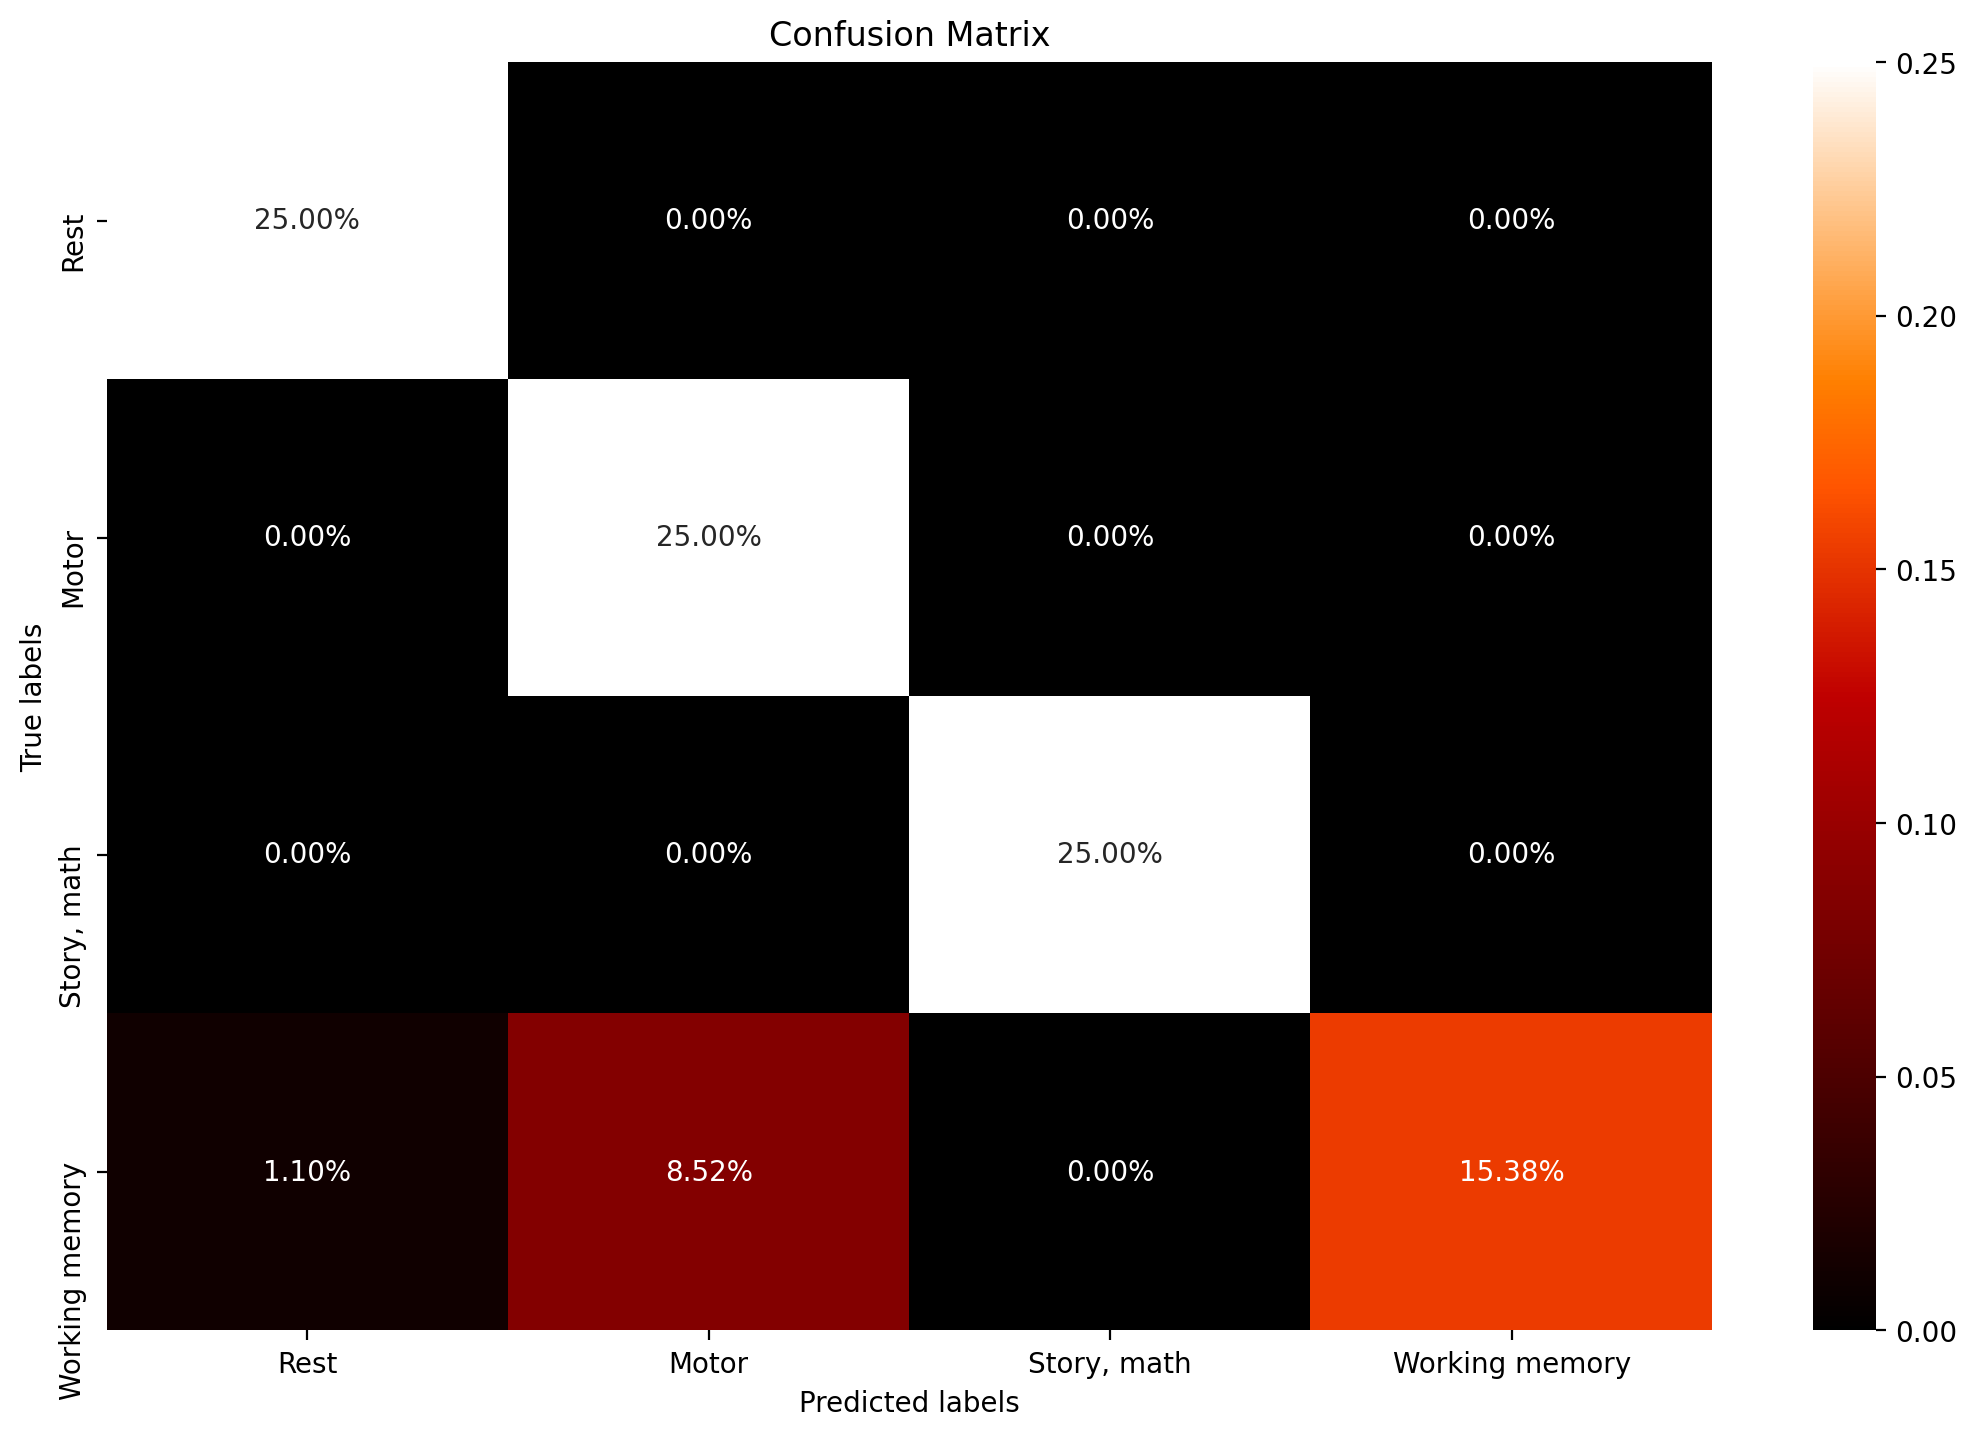

On test set 2 -----------------------------------------------------------
16/16 [==============================] - 76s 5s/step - loss: 5.4414 - accuracy: 0.8019
Accuracy: 0.8018731988472623


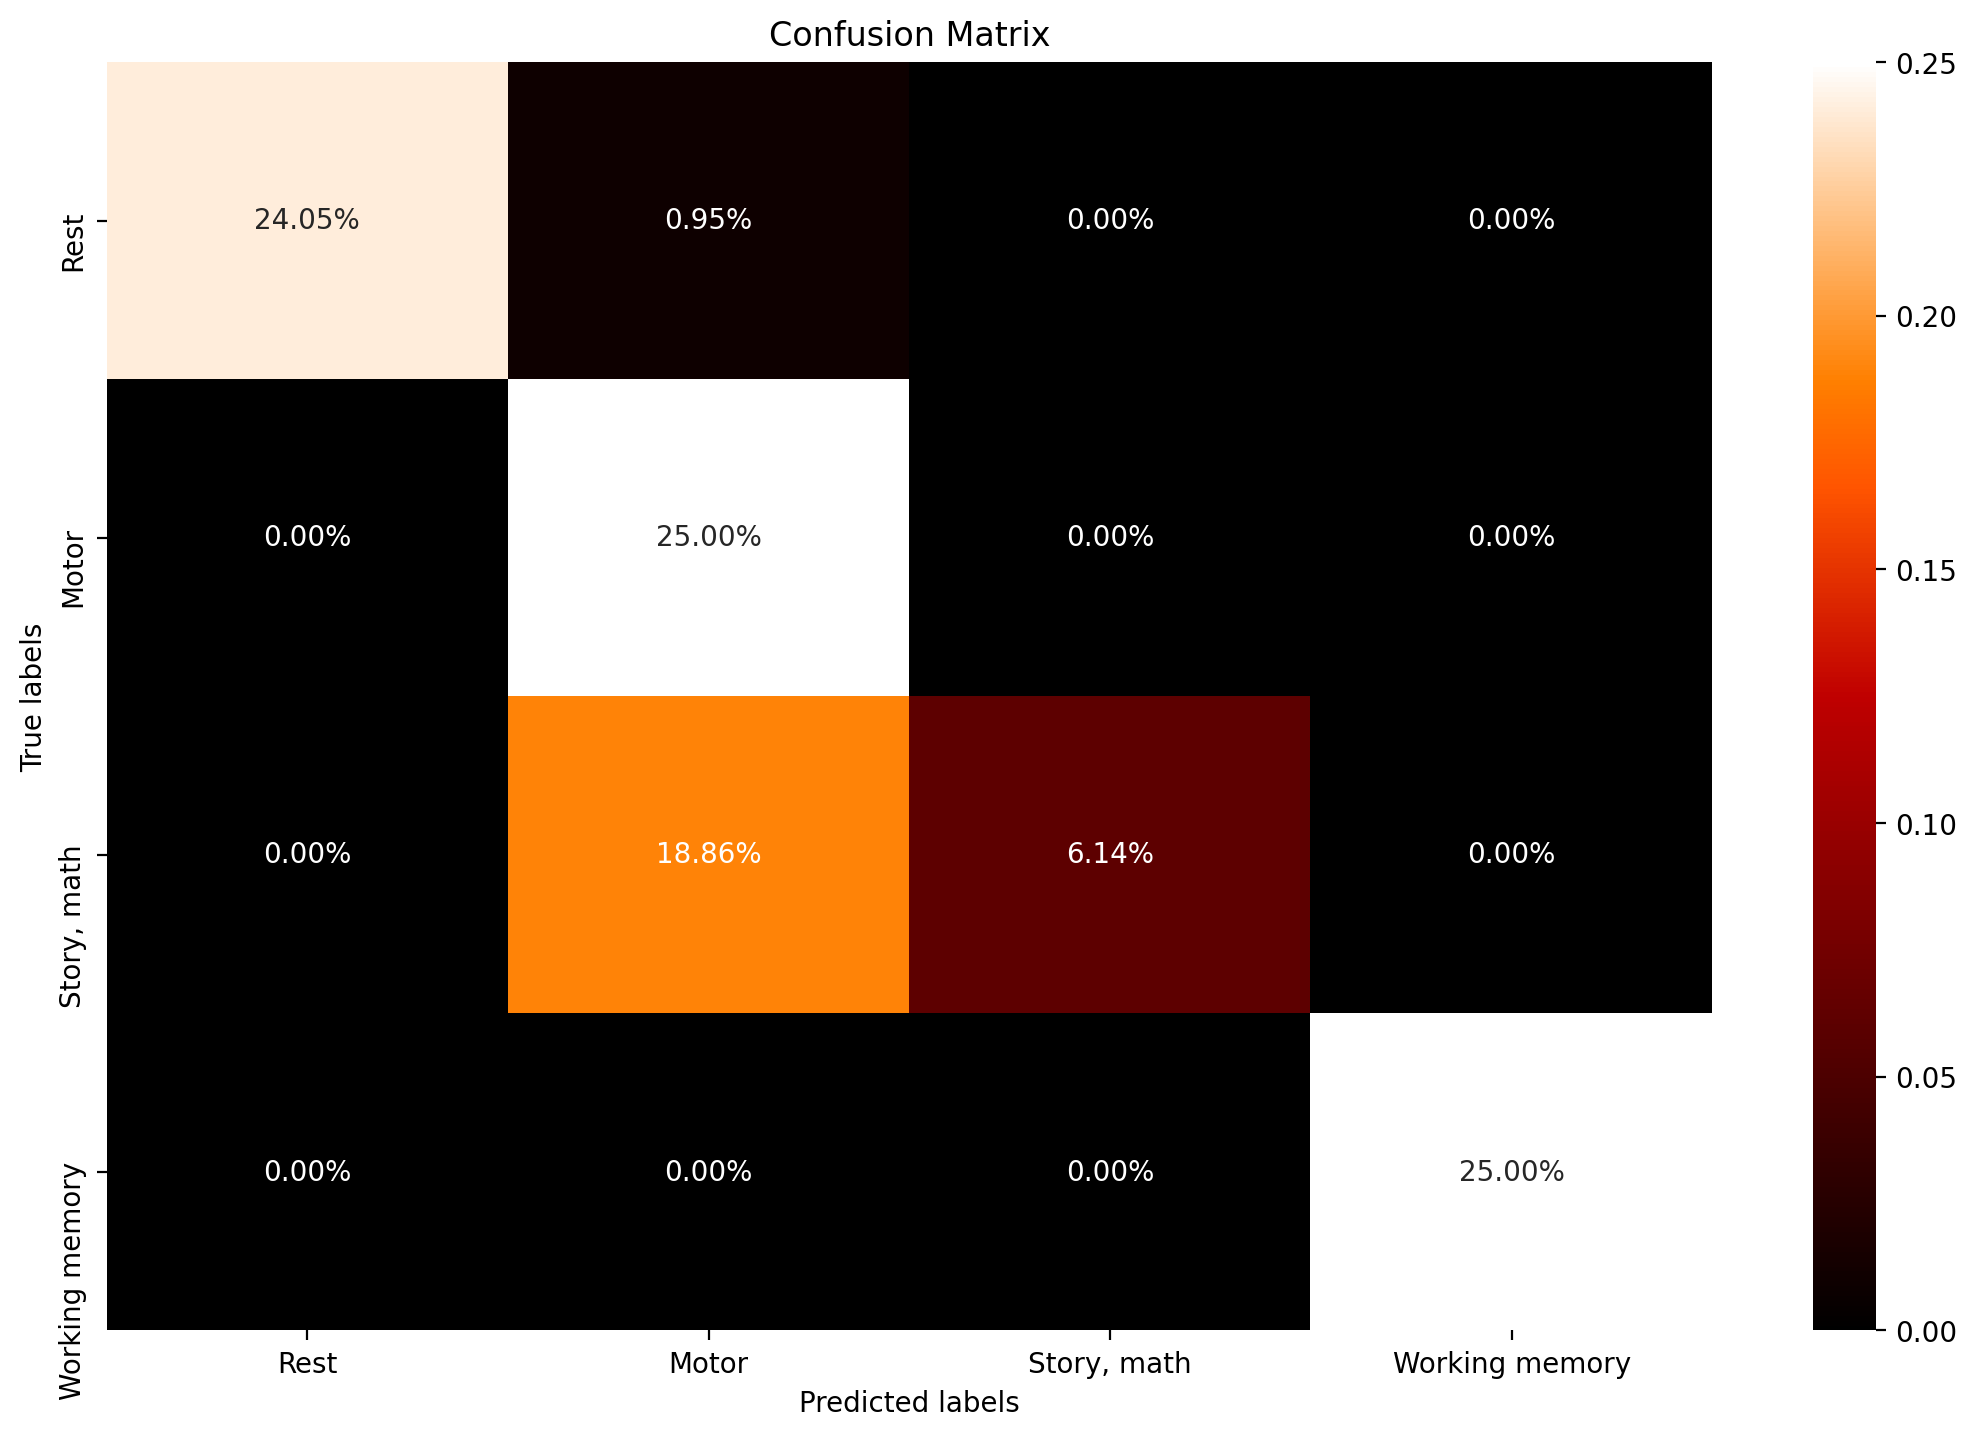

On test set 3 -----------------------------------------------------------
16/16 [==============================] - 74s 5s/step - loss: 2.5323 - accuracy: 0.8174
Accuracy: 0.8173631123919308


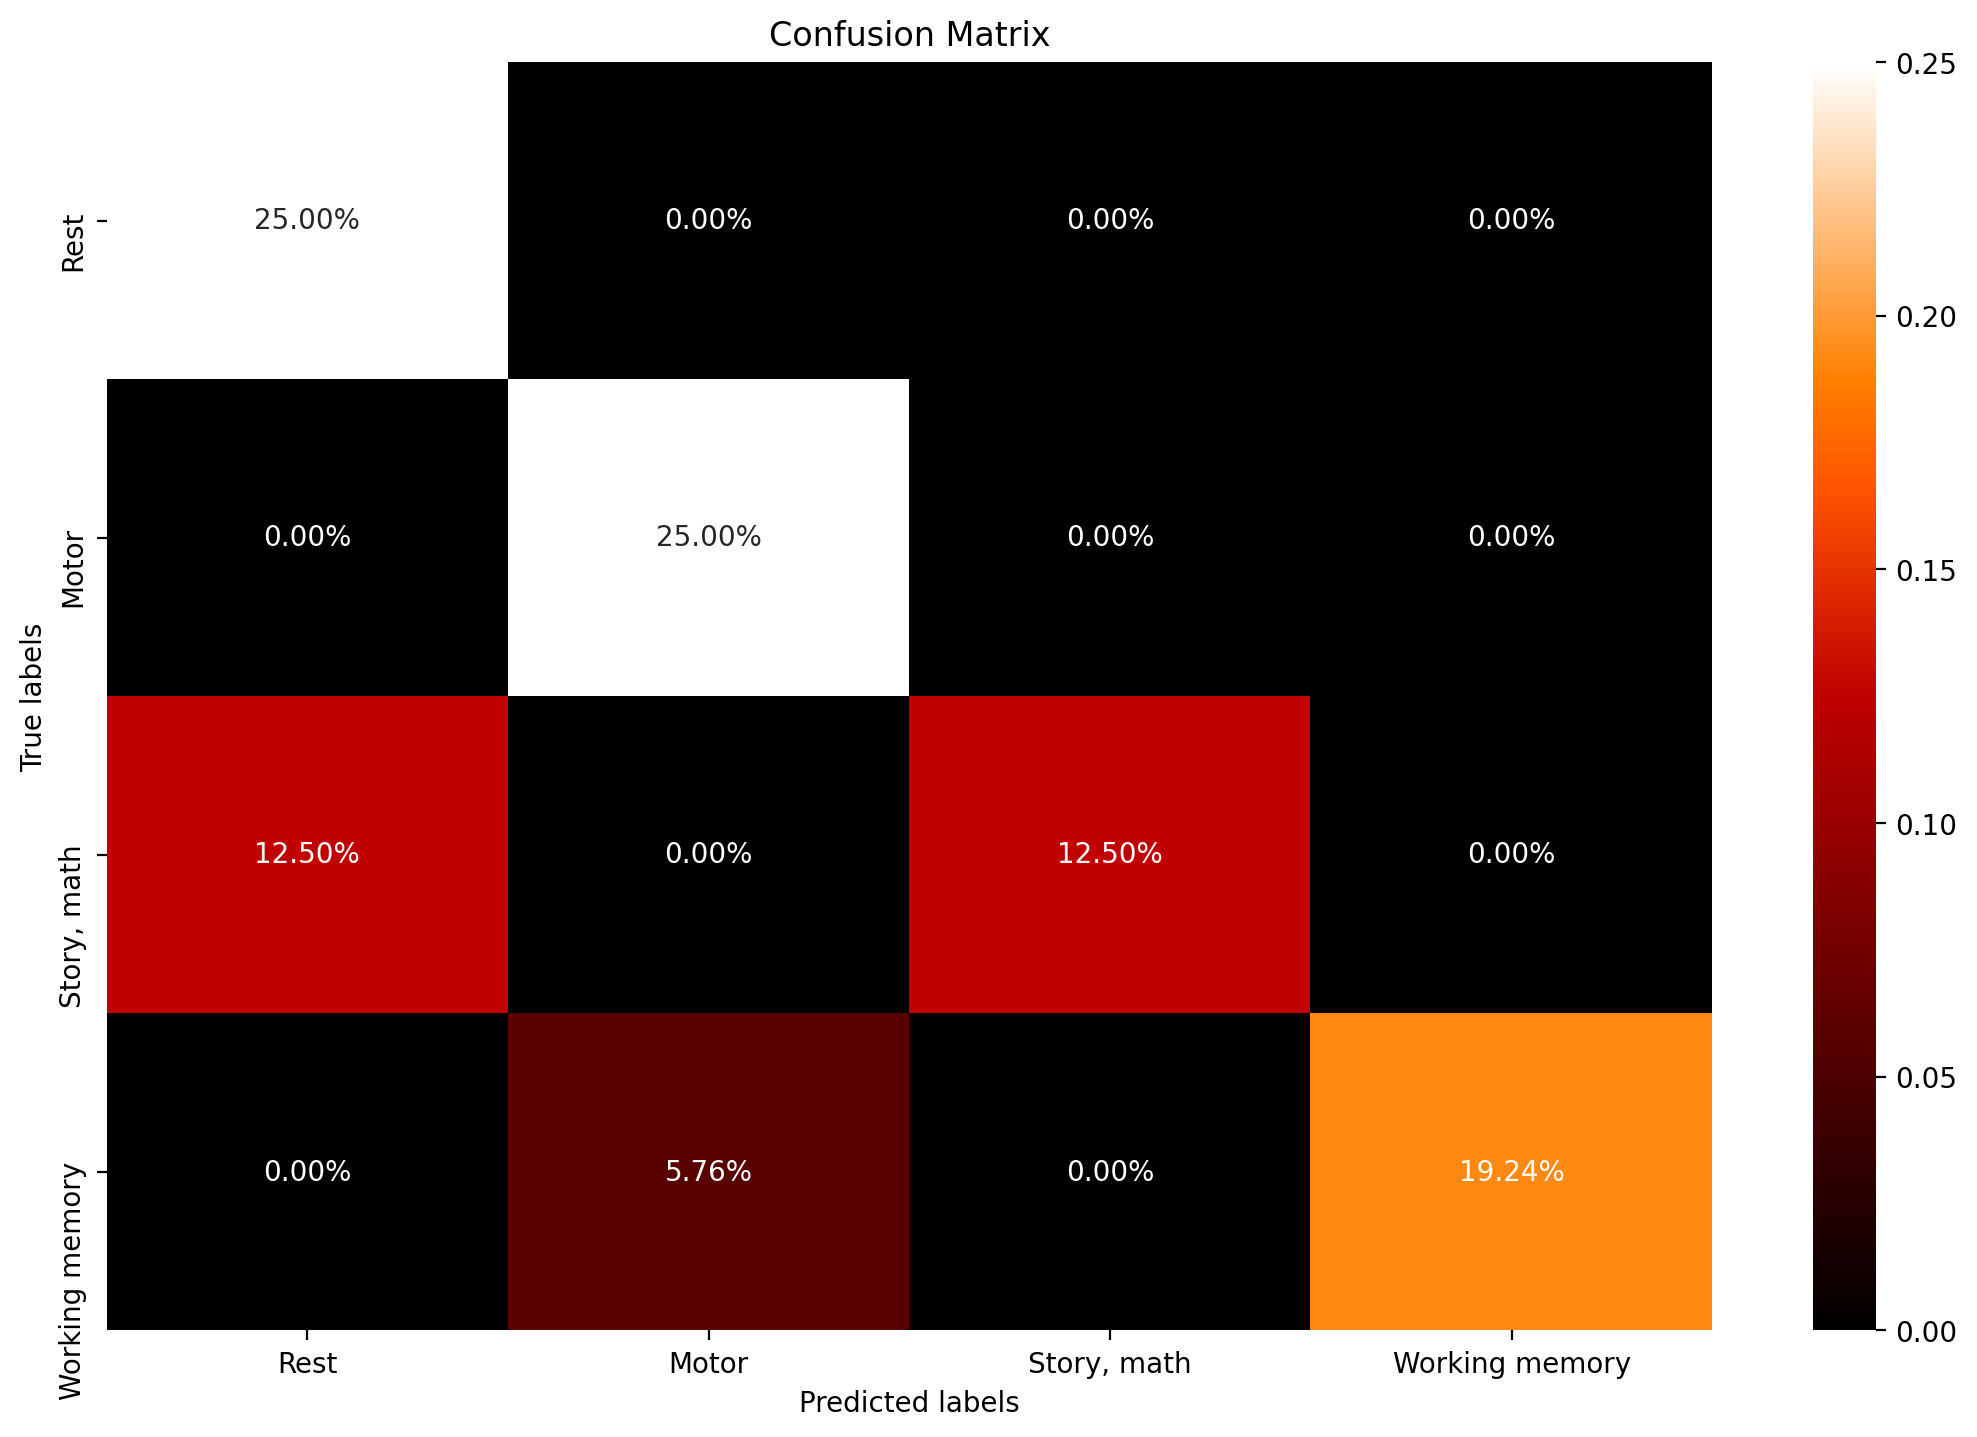

In [19]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import seaborn as sn


# Load model
#print("Loading model...")
#best_model = tf.keras.models.load_model("/content/drive/My Drive/DL-final_project/Saved models/best_model_cross.h5")

print("Evaluating...")
test_data_base_dir = "/content/drive/My Drive/DL-final_project/Data/Cross/"

# Test set 1 ########################################################################
test_gen_1 = test_generator(test_data_base_dir+"test1/", 
                                downsampling_factor=DOWNSAMPLING_FACTOR, 
                                window_size=WINDOW_SIZE, 
                                window_shift=WINDOW_SHIFT, 
                                maxs_array=maxs_array, 
                                mins_array=mins_array)

print("On Test Set 1 -----------------------------------------------------------")
best_model.evaluate(test_gen_1,
                    steps=16)

Y_test_true = []
Y_test_pred = []
for i in range(16):
  X_test, Y_test = next(test_gen_1)
  Y_pred = best_model.predict(X_test)
  Y_pred = np.argmax(Y_pred, axis=1)

  Y_test_true.extend(Y_test.tolist())
  Y_test_pred.extend(Y_pred.tolist())

Y_test_true = np.array(Y_test_true)
Y_test_pred = np.array(Y_test_pred)

accuracy = np.mean(np.equal(Y_test_true,Y_test_pred))
print("Accuracy:", accuracy)

confusion_matrix = metrics.confusion_matrix(Y_test_true, Y_test_pred)

fig, ax= plt.subplots()
fig.set_size_inches(0.7*18.5, 0.8*10.5)
fig.set_dpi(200)
sn.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, 
            fmt='.2%', cmap='gist_heat')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
labels = ["Rest", "Motor", "Story, math", "Working memory"]
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
fig.savefig("/content/drive/My Drive/DL-final_project/Results/Cross/BestModel/bestModel_CM_test1.png")
plt.show()

# Test set 2 ########################################################################
test_gen_2 = test_generator(test_data_base_dir+"test2/", 
                                downsampling_factor=DOWNSAMPLING_FACTOR, 
                                window_size=WINDOW_SIZE, 
                                window_shift=WINDOW_SHIFT, 
                                maxs_array=maxs_array, 
                                mins_array=mins_array)

print("On test set 2 -----------------------------------------------------------")
best_model.evaluate(test_gen_2,
                    steps=16)

Y_test_true = []
Y_test_pred = []
for i in range(16):
  X_test, Y_test = next(test_gen_2)
  Y_pred = best_model.predict(X_test)
  Y_pred = np.argmax(Y_pred, axis=1)

  Y_test_true.extend(Y_test.tolist())
  Y_test_pred.extend(Y_pred.tolist())

Y_test_true = np.array(Y_test_true)
Y_test_pred = np.array(Y_test_pred)

accuracy = np.mean(np.equal(Y_test_true,Y_test_pred))
print("Accuracy:", accuracy)

confusion_matrix = metrics.confusion_matrix(Y_test_true, Y_test_pred)

fig, ax= plt.subplots()
fig.set_size_inches(0.7*18.5, 0.8*10.5)
fig.set_dpi(200)
sn.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, 
            fmt='.2%', cmap='gist_heat')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
labels = ["Rest", "Motor", "Story, math", "Working memory"]
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
fig.savefig("/content/drive/My Drive/DL-final_project/Results/Cross/BestModel/bestModel_CM_test2.png")
plt.show()

# Test set 3 ########################################################################
test_gen_3 = test_generator(test_data_base_dir+"test3/", 
                                downsampling_factor=DOWNSAMPLING_FACTOR, 
                                window_size=WINDOW_SIZE, 
                                window_shift=WINDOW_SHIFT, 
                                maxs_array=maxs_array, 
                                mins_array=mins_array)

print("On test set 3 -----------------------------------------------------------")
best_model.evaluate(test_gen_3,
                    steps=16)

Y_test_true = []
Y_test_pred = []
for i in range(16):
  X_test, Y_test = next(test_gen_3)
  Y_pred = best_model.predict(X_test)
  Y_pred = np.argmax(Y_pred, axis=1)

  Y_test_true.extend(Y_test.tolist())
  Y_test_pred.extend(Y_pred.tolist())

Y_test_true = np.array(Y_test_true)
Y_test_pred = np.array(Y_test_pred)

accuracy = np.mean(np.equal(Y_test_true,Y_test_pred))
print("Accuracy:", accuracy)

confusion_matrix = metrics.confusion_matrix(Y_test_true, Y_test_pred)

fig, ax= plt.subplots()
fig.set_size_inches(0.7*18.5, 0.8*10.5)
fig.set_dpi(200)
sn.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, 
            fmt='.2%', cmap='gist_heat')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
labels = ["Rest", "Motor", "Story, math", "Working memory"]
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
fig.savefig("/content/drive/My Drive/DL-final_project/Results/Cross/BestModel/bestModel_CM_test3.png")
plt.show()